# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=4900, num_validation=100, num_test=100):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
#   X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  X_train = pickle.load(open("X_train_5000", "rb"))
  y_train = pickle.load(open("y_train_5000", "rb"))
  X_test = pickle.load(open("X_test_500", "rb"))
  y_test = pickle.load(open("y_test_500", "rb"))
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 4900 images
Done extracting features for 2000 / 4900 images
Done extracting features for 3000 / 4900 images
Done extracting features for 4000 / 4900 images


## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM
from numpy.random import uniform

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_svm = None

pass
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for count in range(20):
    lr = 10**uniform(-9,-7)
    rs = 10**uniform(5,7)
    print lr, rs
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=lr, reg=rs,num_iters=500, verbose=True)

    y_train_pred = svm.predict(X_train_feats)
    train_ac = np.mean(y_train == y_train_pred)
    print 'training accuracy: %f' % (train_ac, )

    y_val_pred = svm.predict(X_val_feats)
    val_ac = np.mean(y_val == y_val_pred)
    print 'validation accuracy: %f' % (val_ac, )

    if(val_ac > best_val):
        best_val = val_ac
        best_svm = svm

    results[(lr,rs)] = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

2.40269564202e-09 923291.841418
iteration 0 / 500: loss 704.414778
iteration 100 / 500: loss 455.003063
iteration 200 / 500: loss 295.039263
iteration 300 / 500: loss 192.465531
iteration 400 / 500: loss 126.664208
training accuracy: 0.112653
validation accuracy: 0.100000
6.78290304824e-09 447630.757836
iteration 0 / 500: loss 368.263212
iteration 100 / 500: loss 204.572435
iteration 200 / 500: loss 115.465206
iteration 300 / 500: loss 66.950177
iteration 400 / 500: loss 40.545239
training accuracy: 0.102653
validation accuracy: 0.140000
4.50619104972e-08 181753.893163
iteration 0 / 500: loss 145.129590
iteration 100 / 500: loss 35.284995
iteration 200 / 500: loss 14.071990
iteration 300 / 500: loss 9.981083
iteration 400 / 500: loss 9.189163
training accuracy: 0.152449
validation accuracy: 0.130000
2.87408308816e-09 817439.301349
iteration 0 / 500: loss 614.995831
iteration 100 / 500: loss 387.576214
iteration 200 / 500: loss 245.503682
iteration 300 / 500: loss 156.751953
iteration 4

In [7]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.43


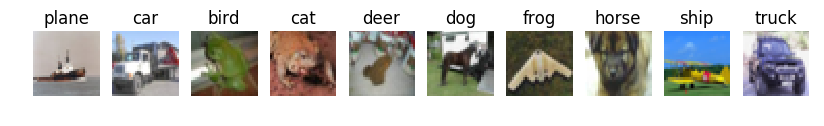

In [11]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 1
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [12]:
print X_train_feats.shape

(4900, 155)


In [30]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 100
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Train the network
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=1000, batch_size=1000,
            learning_rate=0.005, learning_rate_decay=0.99,
            reg=0.5, verbose=True)
val_acc = np.mean(net.predict(X_val_feats) == y_val)
print 'Validation accuracy: ', val_acc
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 1000: loss 2.302627
iteration 100 / 1000: loss 2.302616
iteration 200 / 1000: loss 2.302415
iteration 300 / 1000: loss 2.302368


KeyboardInterrupt: 

In [ ]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print test_acc

# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!